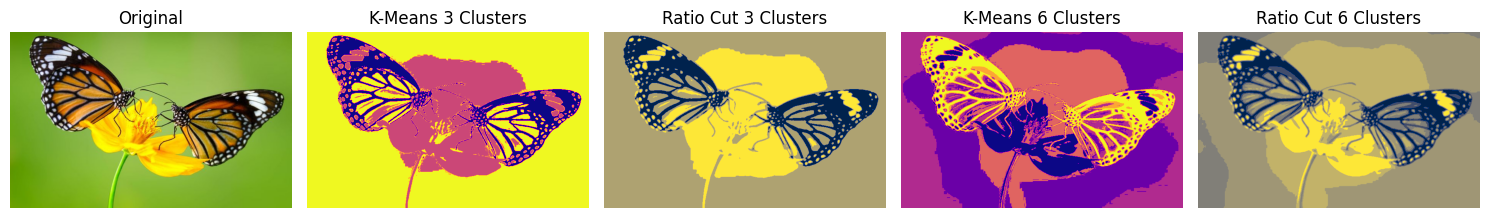

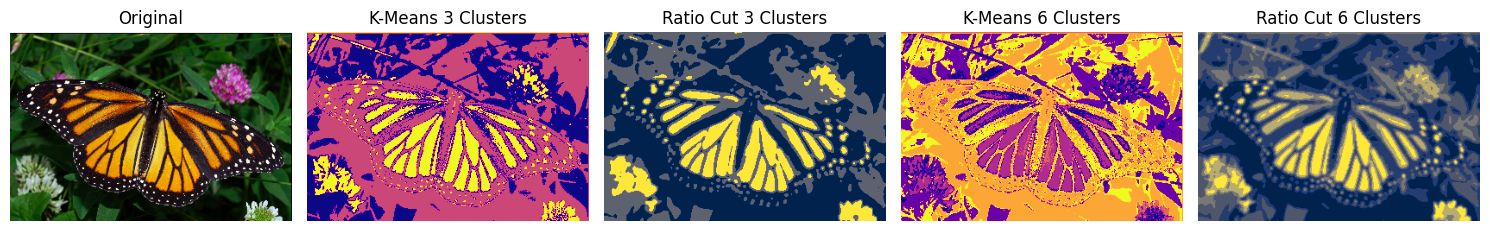

In [5]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

class KMeansFromScratch:
    def __init__(self, n_clusters=3, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centers = None

    def initialize_centers(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        self.centers = X[random_idx[:self.n_clusters]]

    def compute_distance(self, X, center):
        return np.linalg.norm(X - center, axis=1)

    def assign_labels(self, X):
        distances = np.array([self.compute_distance(X, center) for center in self.centers]).T
        return np.argmin(distances, axis=1)

    def update_centers(self, X, labels):
        new_centers = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
        return new_centers

    def fit(self, X):
        self.initialize_centers(X)
        for i in range(self.max_iter):
            labels = self.assign_labels(X)
            new_centers = self.update_centers(X, labels)
            if np.allclose(self.centers, new_centers, atol=1e-4):
                break
            self.centers = new_centers
        self.labels_ = labels

def load_images_from_folder(folder):
    images = []
    try:
        file_list = os.listdir(folder)
    except FileNotFoundError:
        print(f"Error: The directory {folder} does not exist.")
        return images
    for filename in file_list:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        else:
            print(f"Warning: {filename} could not be read as an image.")
    return images

def display_images(images, titles, colormaps):
    assert len(images) == len(titles) == len(colormaps), "Each image must have a corresponding title and colormap."
    n = len(images)
    plt.figure(figsize=(15, 5 * n))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap=colormaps[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def segment_image(image, n_clusters, method='kmeans'):
    if method == 'kmeans':
        kmeans = KMeansFromScratch(n_clusters=n_clusters, max_iter=100)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data = gray.reshape((-1, 1))
        kmeans.fit(data)
        segmented_image = kmeans.labels_.reshape(gray.shape)
        return segmented_image

def ratio_cut_clustering(image, num_clusters):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    Z = gray.reshape((-1, 1))
    Z = np.float32(Z)
    _, labels, (centers) = cv2.kmeans(Z, num_clusters, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    segmented_image = res.reshape((gray.shape))
    return segmented_image

def main():
    folder_path = '/home/planck/NIDHI_SONI/CV_Ass/cv_assignment_2_data/img'  # Update with your path
    images = load_images_from_folder(folder_path)
    num_clusters_list = [3, 6]

    for image in images:
        original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        titles = ['Original']
        segmented_results = [original]
        colormaps = ['viridis']  # Default colormap for the original image

        for num_clusters in num_clusters_list:
            kmeans_segmented = segment_image(image, num_clusters)
            segmented_results.append(kmeans_segmented)
            titles.append(f'K-Means {num_clusters} Clusters')
            colormaps.append('plasma')  # Changed colormap for K-Means

            ratio_cut_segmented = ratio_cut_clustering(image, num_clusters)
            segmented_results.append(ratio_cut_segmented)
            titles.append(f'Ratio Cut {num_clusters} Clusters')
            colormaps.append('cividis')  # Changed colormap for Ratio-Cut

        display_images(segmented_results, titles, colormaps)

if __name__ == "__main__":
    main()
